   N° de train Type de train Date de départ  Places disponibles
0          712       EXPRESS     01/12/2024                  51
1          731       OMNIBUS     01/12/2024                  37
2          211       EXPRESS     03/12/2024                  26
3          412       EXPRESS     05/12/2024                   7
4          431       OMNIBUS     05/12/2024                   2
5          611       EXPRESS     07/12/2024                  33
6          211       EXPRESS     10/12/2024                  63
7          232       OMNIBUS     10/12/2024                 120
8          412       EXPRESS     12/12/2024                  96
9          431       OMNIBUS     12/12/2024                  94
10         611       EXPRESS     14/12/2024                 325
11         632       OMNIBUS     14/12/2024                 143
12         712       EXPRESS     15/12/2024                  44
13         731       OMNIBUS     15/12/2024                 185
14         211       EXPRESS     17/12/2

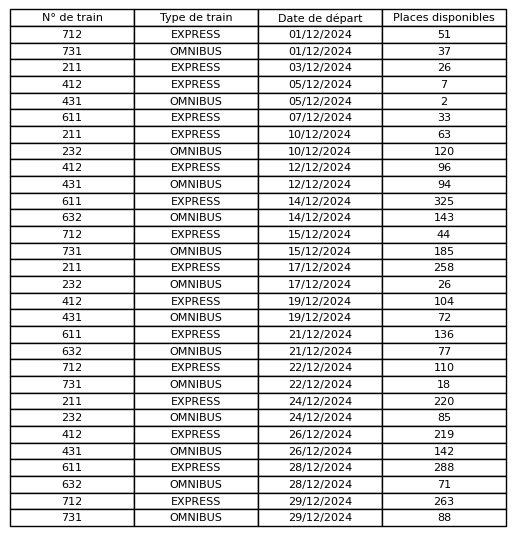

In [2]:
import pymysql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sshtunnel import SSHTunnelForwarder

# Define your SSH and MySQL credentials
ssh_host = '10.120.21.103'
ssh_port = 22
ssh_user = 'setrag'
ssh_password = 'Wabjtam,123'

mysql_host = '192.168.21.69'
mysql_port = 3306
mysql_user = 'galera'
mysql_password = 'galera'
mysql_db = 'setrag_beta1'

# Establish the SSH tunnel
with SSHTunnelForwarder(
    (ssh_host, ssh_port),
    ssh_username=ssh_user,
    ssh_password=ssh_password,
    remote_bind_address=(mysql_host, mysql_port)
) as tunnel:
    # Connect to the MySQL database
    connection = pymysql.connect(
        host='127.0.0.1',
        user=mysql_user,
        password=mysql_password,
        db=mysql_db,
        port=tunnel.local_bind_port
    )

    # Execute a query
    with connection.cursor() as cursor:
        cursor.execute("""
                        SELECT t.number AS 'N° de train',
                            tp.label AS 'Type de train',
                            DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%d/%m/%Y") AS "Date de départ",
                            count(sbr.seat_occupation_flag) AS 'Places disponibles'
                        FROM train AS t
                        INNER JOIN seat_booking_record AS sbr
                        ON sbr.train_id = t.id
                        INNER JOIN seat AS s
                        ON s.id = sbr.seat_id
                        INNER JOIN car AS c
                        ON c.id = s.car_id
                        INNER JOIN train_type tp
                        ON t.train_type_id = tp.id
                        WHERE (t.planned_date/1000) between UNIX_TIMESTAMP('2024-12-01 00:00:00') AND UNIX_TIMESTAMP('2024-12-31 23:59:59') 
                        AND sbr.seat_occupation_flag = 0 
                        AND tp.label IN ('EXPRESS', 'OMNIBUS') 
                        GROUP BY DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), '%d/%m/%Y'), t.number
        """)
        result = cursor.fetchall()
        field_names = [i[0] for i in cursor.description]
        #print(field_names)
        df = pd.DataFrame(result, columns=["N° de train", "Type de train", "Date de départ", "Places disponibles"])
        print(df)

        # Plot the DataFrame as a table
        fig, ax = plt.subplots()
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
        # Save the table as a JPEG image
        plt.savefig('data_table.jpg', format='jpeg')
        print("The data table has been successfully saved as data_table.jpg")

    # Close the connection
    connection.close()